### Study on bias and interpretable models - SCHOOL PROJECT
*Nathan Lauga - December 2018*

*****

Hello world ! ✋



## Table of content

* [1. Load and prepare data](#1)
    * [1.1 Load libraries](#1.1)
    * [1.2 Load the data](#1.2)
    * [1.3 Quick EDA](#1.3)
    * [1.4 Work with feature](#1.4)
* 2. [AIF360 Introduction](#2)
    * [2.1 Create dataset using aif360](#2.1)
    * [2.2 Quick look on the dataset](#2.2)
    * [2.3 First model](#2.3)
* 3. [Bias and Fairness](#3)
    * [3.1 Metrics](#3.1)
        * [3.1.1 Statistical Parity Difference](#3.1.1)
        * [3.1.2 Equal Opportunity Difference](#3.1.2)
        * [3.1.3 Average Absolute Odds Difference](#3.1.3)
        * [3.1.4 Disparate Impact](#3.1.4)
        * [3.1.5 Theil Index](#3.1.5)
    * [3.2 How to fix it ?](#3.2)
        * [3.2.1 Pre-processing algorithms](#3.2.1)
            * [3.2.1.1 Disparate impact remove](#3.2.1.1)
            * [3.2.1.2 Learning fair representations](#3.2.1.2)
            * [3.2.1.3 Optimized preprocessing](#3.2.1.3)
            * [3.2.1.4 Reweighing](#3.2.1.4)
        * [3.2.2 In-processing algorithms](#3.2.2)
            * [3.2.2.1 Adversarial Debiasing](#3.2.2.1)
            * [3.2.2.2 Prejudice Remover Regularizer](#3.2.2.2)
        * [3.2.3 Post-processing algorithms](#3.2.3)
            * [3.2.3.1 Calibrated Equality of Odds](#3.2.3.1)
            * [3.2.3.2 Equality of Odds](#3.2.3.2)
            * [3.2.3.3 Reject Option Classification](#3.2.3.3)
* 4. [Interpretable model](#4)
    * [4.1 Feature importance](#4.1)
    * [4.2 LIME](#4.2)
    * [4.3 SHAP](#4.3)
* 5. [Conclusion](#5)

## <a id='1'>1. Load and prepare data</a>

### <a id='1.1'>1.1 Load libraries</a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# Custom visualisation functions in visualitions.py file
from visualisations import plot_fair_metrics

# Custom metrics functions in metrics.py file
from metrics import fair_metrics

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

import lime
import lime.lime_tabular
import shap

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
import tensorflow as tf

from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

### <a id='1.2'>1.2 Load the data</a>

I choose to use the Adult dataset that you can find on the following link : [UCI Machine Learning Repository : Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult)

In [2]:
cols = ["Age", "Workclass", "Final Weight", "Education", "Education-Num", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week", "Country", "Income"]
data = pd.read_csv('./data/adult.csv', header=None)
data.columns = cols

### <a id='1.3'>1.3 Quick EDA</a>

In [3]:
data.head()

Age          Workclass  Final Weight   Education  Education-Num  \
0   39          State-gov         77516   Bachelors             13   
1   50   Self-emp-not-inc         83311   Bachelors             13   
2   38            Private        215646     HS-grad              9   
3   53            Private        234721        11th              7   
4   28            Private        338409   Bachelors             13   

        Marital Status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital Gain  Capital Loss  Hours per week         Country  Income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

Since Education-Num is the same as Education but classed by number we can drop it

In [4]:
data.drop(columns=['Education-Num'], inplace=True)

In [5]:
na_count = pd.DataFrame(data.apply(lambda x : x.isna()).sum()).transpose()
na_count

Age  Workclass  Final Weight  Education  Marital Status  Occupation  \
0    0          0             0          0               0           0   

   Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0             0     0    0             0             0               0   

   Country  Income  
0        0       0

This dataset doesn't have any NA value so we don't have to work with that.

In [6]:
def plot_bar(data, column, color='#2980b9', orientation = 'h', type=None):
    data =  data[column].dropna().value_counts(ascending=True)

    x, y = (data.values, data.index) if orientation == 'h' else (data.index, data.values)
    trace = go.Bar(x=x, y=y, marker=dict(color=color)
           , opacity=0.9, orientation = orientation)
    layout = go.Layout(barmode='group', title='Bar plot for the '+column+' column', xaxis=dict(type=type))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)
    
def plot_histo(data, column, type=None):
    trace = go.Histogram(x=data[column].dropna())
    layout = go.Layout(title='Histogram of the '+column+' column'
                       , yaxis= dict(type=type,autorange=True))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)

#### Continuous columns

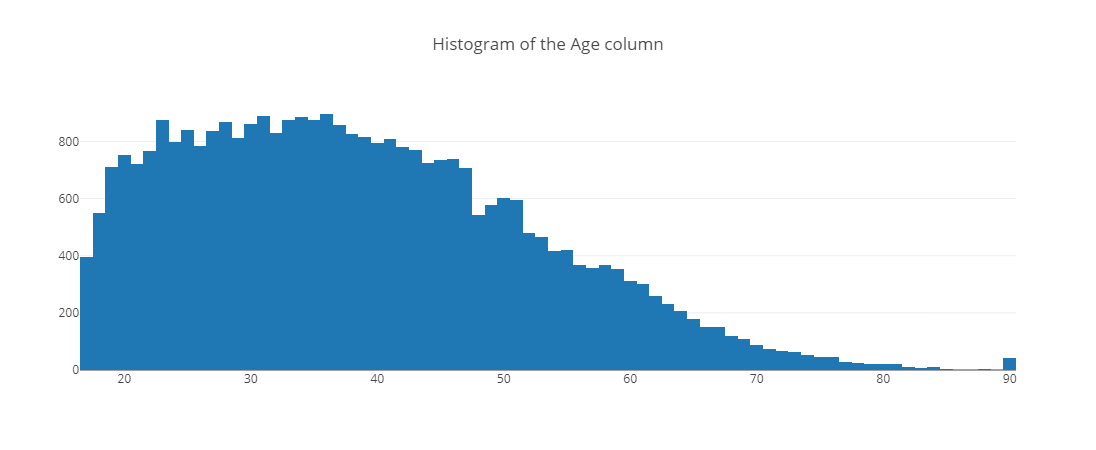

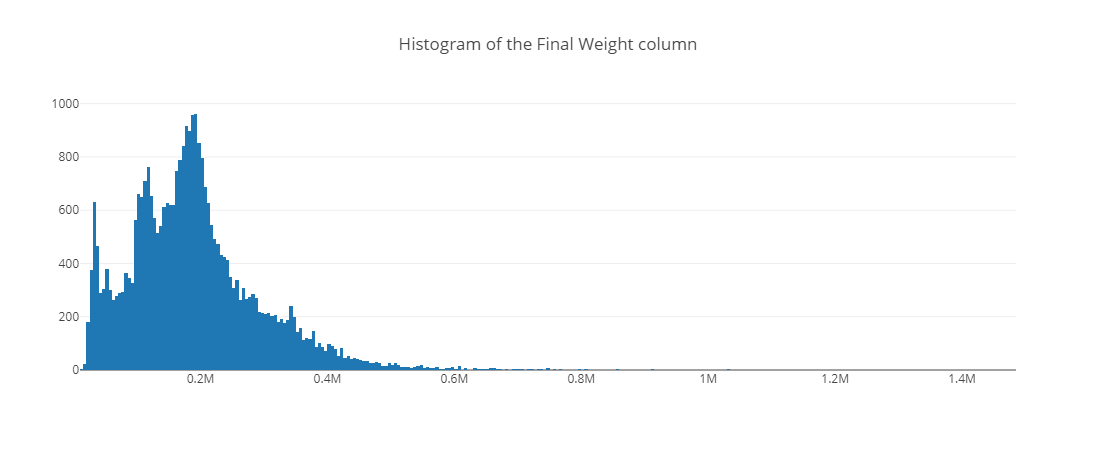

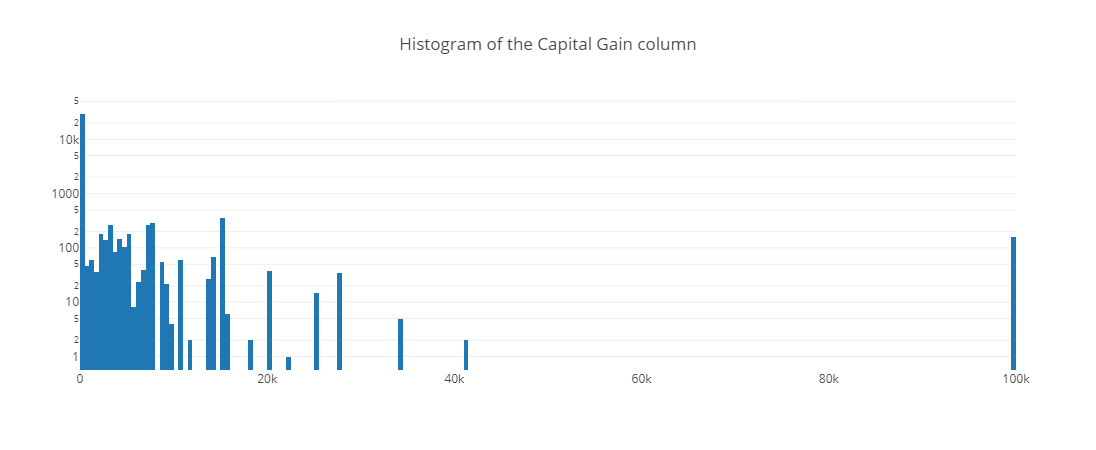

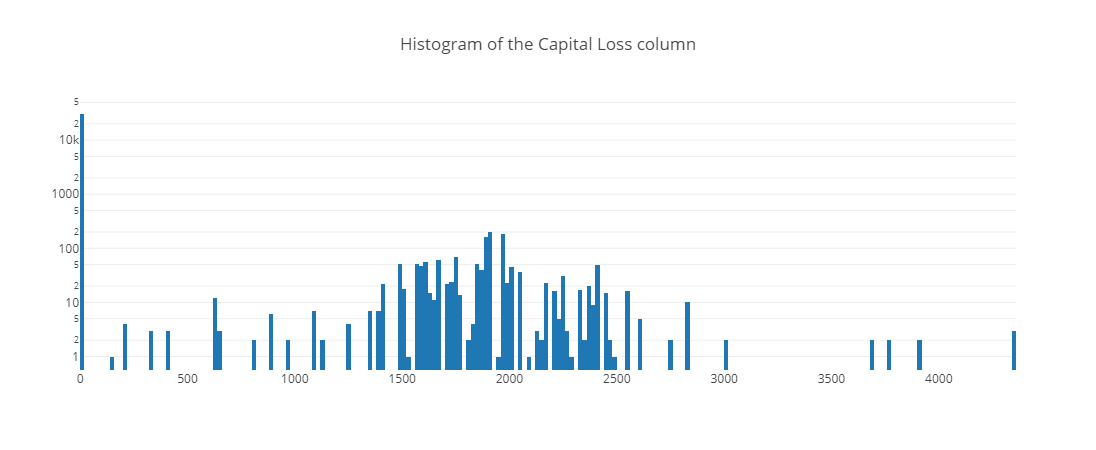

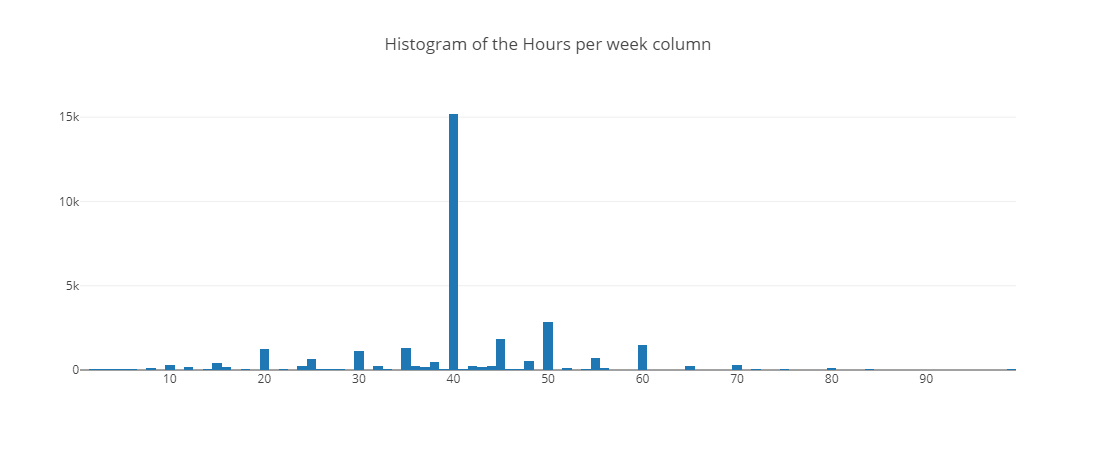

In [7]:
# print(data.columns.values)
display(Markdown('#### Continuous columns'))
plot_histo(data, 'Age')
plot_histo(data, 'Final Weight')
plot_histo(data, 'Capital Gain', type='log')
plot_histo(data, 'Capital Loss', type='log')
plot_histo(data, 'Hours per week')

#### Categorical columns

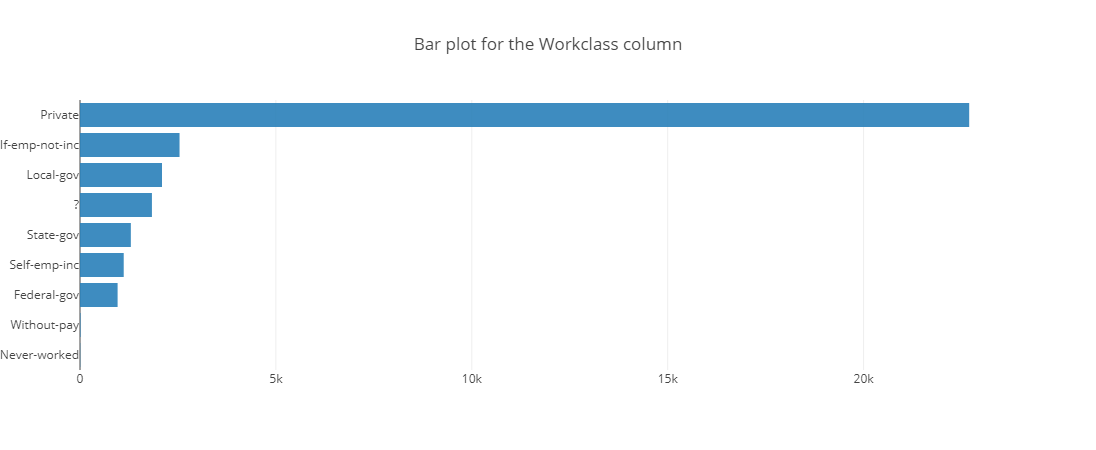

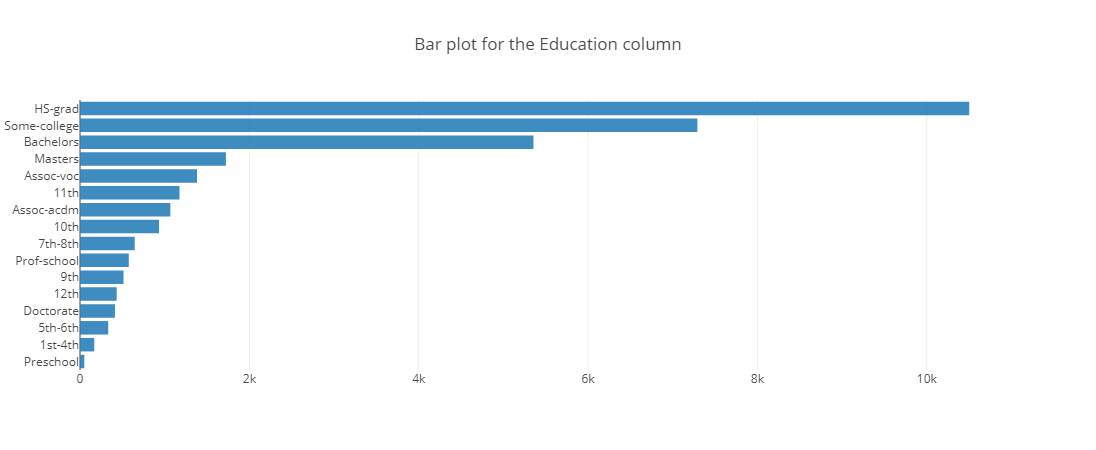

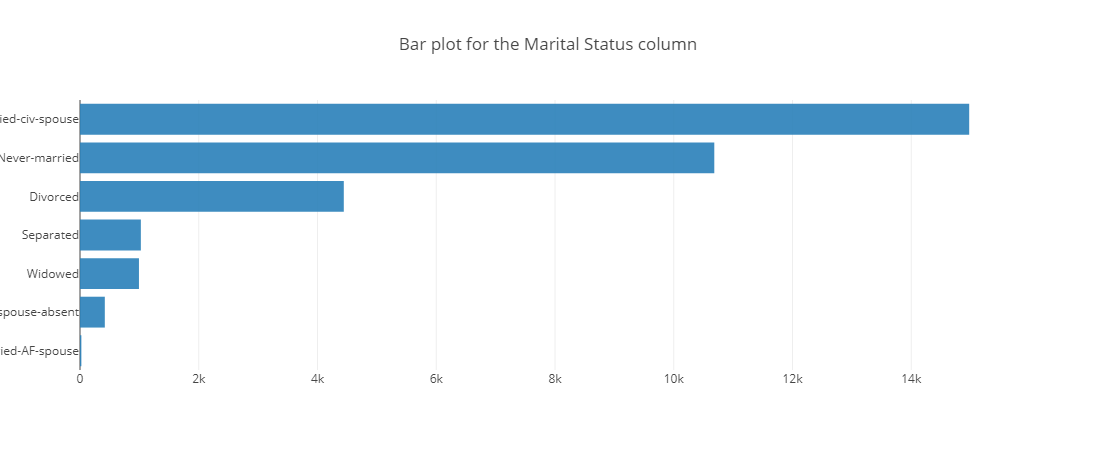

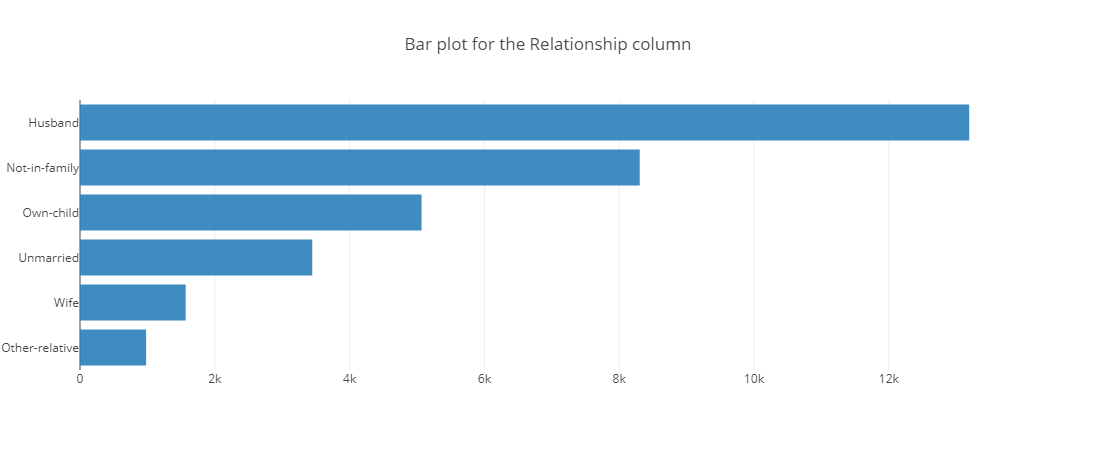

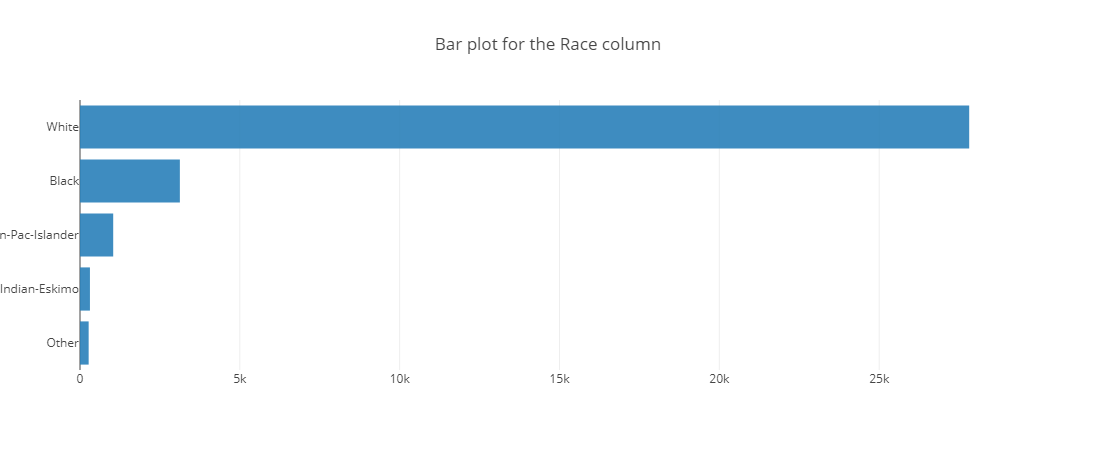

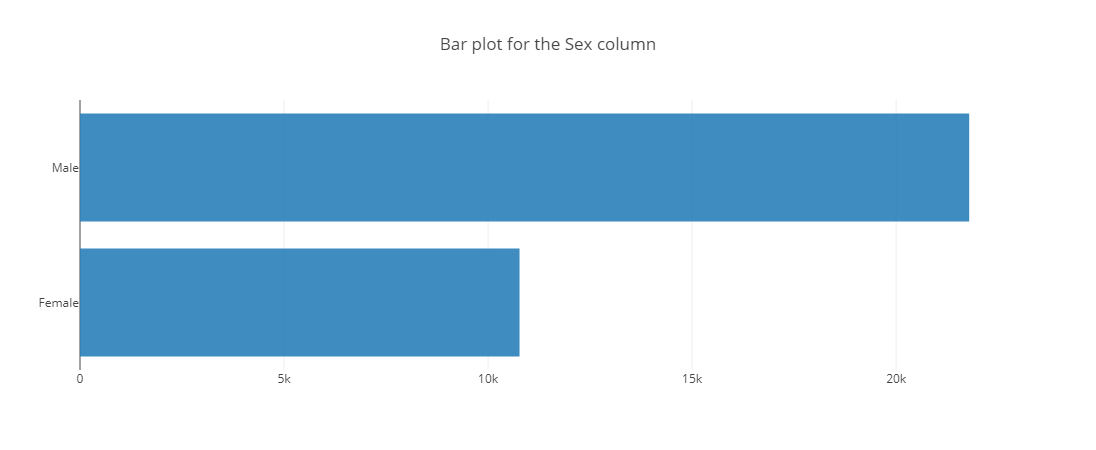

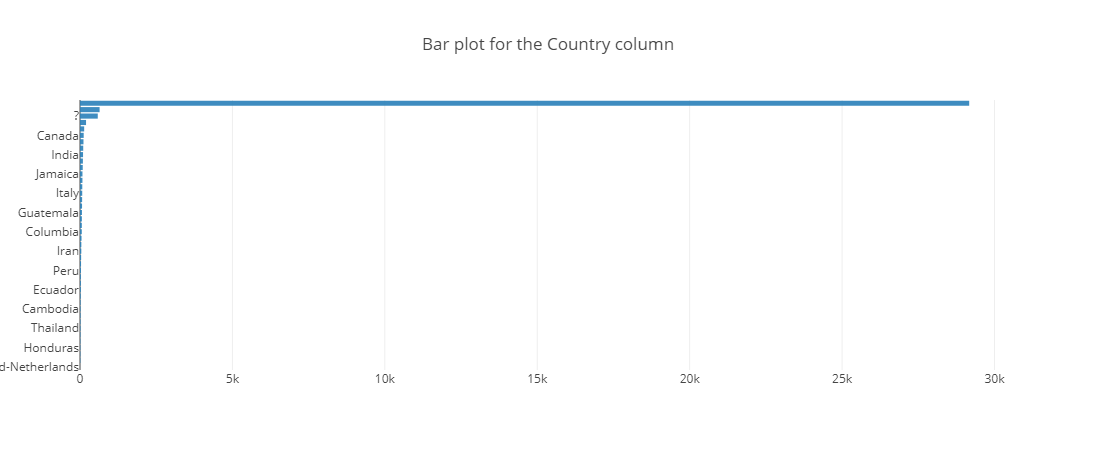

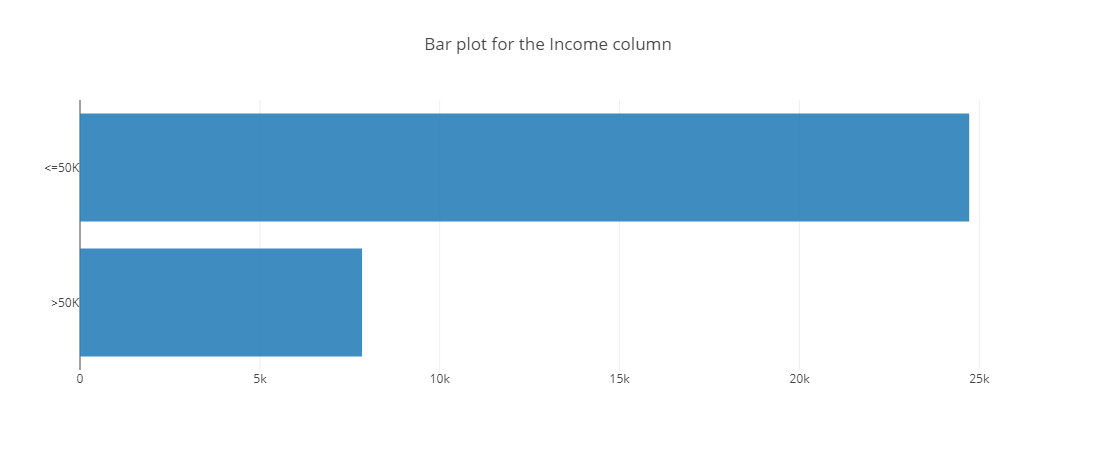

In [8]:
display(Markdown('#### Categorical columns'))
plot_bar(data, 'Workclass')
plot_bar(data, 'Education')
plot_bar(data, 'Marital Status')
plot_bar(data, 'Relationship')
plot_bar(data, 'Race')
plot_bar(data, 'Sex')
plot_bar(data, 'Country')
plot_bar(data, 'Income')

### <a id='1.4'>1.4 Work with feature</a>

#### Encoding categorical columns

*Why encoding and not dummies ?*

Later in the notebook I will use lime and shap libraries to interpret the model but with dummies values it just get the data to be incoherent (I will explain it later).

In [9]:
categorical_features = ["Workclass", "Education", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Country", "Income"]
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

numerical_features = [c for c in data.columns.values if c not in categorical_features]

In [10]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le
    
for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    data_encoded[feature] = MinMaxScaler().fit_transform(val)
    
data_encoded = data_encoded.astype(float)

In [11]:
data_encoded.head()

Age  Workclass  Final Weight  Education  Marital Status  Occupation  \
0  0.301370        7.0      0.044302        9.0             4.0         1.0   
1  0.452055        6.0      0.048238        9.0             2.0         4.0   
2  0.287671        4.0      0.138113       11.0             0.0         6.0   
3  0.493151        4.0      0.151068        1.0             2.0         6.0   
4  0.150685        4.0      0.221488        9.0             2.0        10.0   

   Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0           1.0   4.0  1.0       0.02174           0.0        0.397959   
1           0.0   4.0  1.0       0.00000           0.0        0.122449   
2           1.0   4.0  1.0       0.00000           0.0        0.397959   
3           0.0   2.0  1.0       0.00000           0.0        0.397959   
4           5.0   2.0  0.0       0.00000           0.0        0.397959   

   Country  Income  
0     39.0     0.0  
1     39.0     0.0  
2     39.0     0.0  
3     39.0     0.0  
4      5.0     0.0

## <a id='2'>2. AIF360 Introduction</a>
### <a id='2.1'>2.1 Create dataset using aif360</a>

In [12]:
privileged_sex = np.where(categorical_names['Sex'] == ' Male')[0]
privileged_race = np.where(categorical_names['Race'] == ' White')[0]

In [13]:
data_orig = StandardDataset(data_encoded, 
                           label_name='Income', 
                           favorable_classes=[1], 
                           protected_attribute_names=['Sex', 'Race'], 
                           privileged_classes=[privileged_sex, privileged_race])

### <a id='2.2'>2.2 Quick look on the dataset</a>

In [14]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(data_orig.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(data_orig.favorable_label, data_orig.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(data_orig.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(data_orig.privileged_protected_attributes, data_orig.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(data_orig.feature_names)

#### Dataset shape

(32561, 13)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Sex', 'Race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([4.])] [array([0.]), array([0., 1., 2., 3.])]


#### Dataset feature names

['Age', 'Hours per week', 'Relationship', 'Capital Gain', 'Workclass', 'Capital Loss', 'Country', 'Race', 'Marital Status', 'Final Weight', 'Education', 'Sex', 'Occupation']


### <a id='2.3'>2.3 First model</a>

#### Split into train and test set

In [15]:
np.random.seed(42)

data_orig_train, data_orig_test = data_orig.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print(data_orig_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print(data_orig_test.features.shape)

#### Train Dataset shape

(22792, 13)


#### Test Dataset shape

(9769, 13)


#### Training the model : classic Random Forest 

In [16]:
def train_model(model, dataset):
    X_train = dataset.features
    y_train = dataset.labels.ravel()
    
    # Train the model
    model.fit(X_train, y_train, sample_weight=dataset.instance_weights)
    
    return model

# Model to learn
rf = RandomForestClassifier(n_estimators=100)

# Train and save the model
rf_orig = train_model(rf, data_orig_train)

#### Predict on test set

In [17]:
X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()

Now we have a model (Random forest) that is trained with the training dataset and the prediction of the test set. So in a first place let's check the performance of our model (accuracy, F1 Score, confusion matrix, ...).

#### Performance of the model

In [18]:
def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred) 
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(matrix, annot=True,cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    
    ax = fig.add_subplot(1,2,2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

#### Accuracy of the model :

0.8601699252738254


#### F1 score of the model :

0.6826208178438662


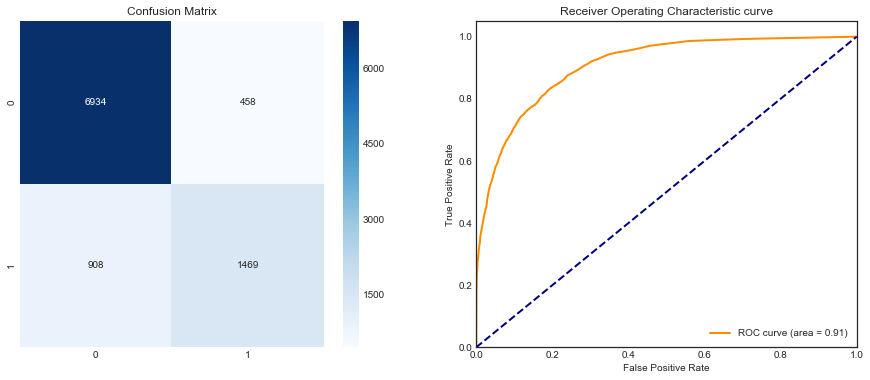

In [19]:
plot_model_performance(rf_orig, data_orig_test.features, y_test)

## <a id='3'>3. Bias and Fairness</a>

Today, a problem of the model that can be produce by Machine Learning is bias that data can have. So a question is how to measure those bias and how to avoid them. In python there is a package produced by IBM called [aif360](https://github.com/IBM/AIF360) that can gives us some metrics and algorithms to know if our data / model are bias and to get a fair model.

### <a id='3.1'>3.1 Metrics</a>

So with aif360 we have some metrics that indicate if our data or model are bias. I will use 5 metrics : 
* Statistical Parity Difference
* Equal Opportunity Difference
* Average Absolute Odds Difference
* Disparate Impact
* Theil Index

#### <a id='3.1.1'>3.1.1 Statistical Parity Difference</a>

This measure is based on the following formula : 

$$ Pr(Y=1|D=unprivileged) - Pr(Y=1|D=privileged) $$

Here the bias or *statistical imparity* is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1.

So it has to be close to **0** so it will be fair.

Also you can find more details about that here : [One definition of algorithmic fairness: statistical parity](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/)


#### <a id='3.1.2'>3.1.2 Equal Opportunity Difference</a>

This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula :

$$ TPR_{D=unprivileged} - TPR_{D=privileged} $$ 

Same as the previous metric we need it to be close to **0**.

#### <a id='3.1.3'>3.1.3 Average Absolute Odds Difference</a>

This measure is using both false positive rate and true positive rate to calculate the bias. It's calculating the equality of odds with the next formula :

$$ \frac{1}{2}[|FPR_{D=unprivileged} - FPR_{D=privileged} | + | TPR_{D=unprivileged} - TPR_{D=privileged}|]$$

It needs to be equal to **0** to be fair.

#### <a id='3.1.4'>3.1.4 Disparate Impact</a>

For this metric we use the following formula :

$$ \frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)} $$

Like the first metric we use both probabities of a random individual drawn from unprivileged or privileged with a label of 1 but here it's a ratio. 

It changes the objective, for the disparate impact it's **1** that we need.

#### <a id='3.1.5'>3.1.5 Theil Index</a>

This measure is also known as the generalized entropy index but with $\alpha$ equals to 1 (more informations on [the Wikipedia page](https://en.wikipedia.org/wiki/Generalized_entropy_index)). So we can calculate it with this formula :

$$ \frac{1}{n} \sum_{i=0}^{n} \frac{b_i}{\mu} ln \frac{b_i}{\mu} $$ 

Where $b_i = \hat{y}_i - y_i + 1 $

So it needs to be close to **0** to be fair.


With these differents metrics we can see that for some we need the prediction and for others just the original dataset. This is why we will use 2 classes of the aif360 package : `ClassificationMetric` and `BinaryLabelDatasetMetric`. 

For the first one we need the prediction so we can have the following metrics : 
* Equal Opportunity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.equal_opportunity_difference)
   
`equal_opportunity_difference()`
* Average Absolute Odds Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.average_abs_odds_difference)

`average_abs_odds_difference()`
* Theil Index : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.theil_index)

`theil_index()`

Then for the metrics that don't require prediction (the second class) we can use them with the following functions : 
* Statistical Parity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.BinaryLabelDatasetMetric.statistical_parity_difference)

`statistical_parity_difference()`
* Disparate Impact : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.disparate_impact)

`disparate_impact()`


Now I construct a `DataFrame` that will keep the values of the differents metrics I talked just above with a function. 

In [20]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Sex attribute :

With default thresholds, bias against unprivileged group detected in **3** out of 5 metrics

#### For the Race attribute :

With default thresholds, bias against unprivileged group detected in **4** out of 5 metrics

statistical_parity_difference  equal_opportunity_difference  \
objective                       0.000000                      0.000000   
Sex                            -0.179903                     -0.118065   
Race                           -0.163158                     -0.400113   

           average_abs_odds_difference  disparate_impact  theil_index  
objective                     0.000000          1.000000     0.000000  
Sex                           0.094164          0.299579     0.115291  
Race                          0.220552          0.232345     0.115291

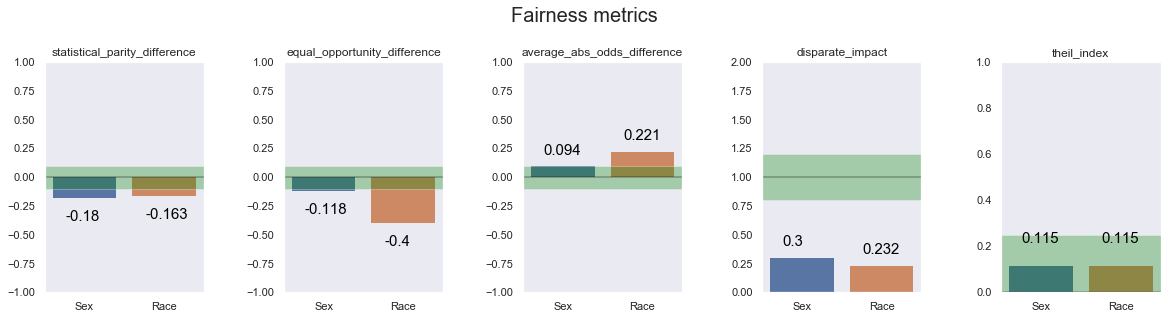

In [21]:
fair = get_fair_metrics_and_plot(data_orig_test, rf_orig)

In [22]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics]], columns=['model', 'fair_metrics'], index=[name]))

In [23]:
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, 'Origin')

As we can see, this first model is biased. The next step is to answer the question : How to fix it ?

### <a id='3.2'>3.2 How to fix it ?</a>

AIF360 use 3 types of algorithms :
* Pre-processing algorithms : they are used before training the model
* In-processing algorithms : they are fair classifiers so it's during the training
* Post-processing algorithms : they are used after training the model

![Fairness pipeline](http://image.noelshack.com/fichiers/2018/50/1/1544437769-fairness-pipeline.png)

This is the **fairness pipeline**. An example instantiation of this generic pipeline consists of loading data into a dataset object, transforming
it into a fairer dataset using a fair pre-processing algorithm, learning a classifier from this transformed dataset, and obtaining
predictions from this classifier. Metrics can be calculated on the original, transformed, and predicted datasets as well as between the
transformed and predicted datasets. Many other instantiations are also possible (more information on [the aif360 paper](https://arxiv.org/pdf/1810.01943.pdf)).

#### <a id='3.2.1'>3.2.1 Pre-processing algorithms </a>

There are 4 pre-processing algorithms but for 3 of them **there is a problem** : it will work only if the dataset have one protected attribute but here we have 2 : *Sex* and *Race*. But let's have a quick intro for all of them and at the end I will use the one that work for my case.

Because this notebook is an exploration of fairness into models I will only use 1 protected attribute : Sex, it will allow me to use almost all the algorithms (but for your information the *Reweighing* algo can works with all protected so that's why I will create a function that gives me the protected and unprotected attributes.

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/preprocessing.html#)



In [24]:
def get_attributes(data, only_one=True):
    unprivileged_groups = []
    privileged_groups = []
    
    for attr in data.protected_attribute_names:
            idx = data.protected_attribute_names.index(attr)
            privileged_groups.append({attr:data.privileged_protected_attributes[idx]}) 
            unprivileged_groups.append({attr:data.unprivileged_protected_attributes[idx]}) 
            if only_one:
                break

    return privileged_groups, unprivileged_groups

*****
##### <a id='3.2.1.1'>3.2.1.1 Disparate impact remover</a>
Source : [Feldman et al., 2015](https://dl.acm.org/citation.cfm?doid=2783258.2783311)

Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups.
If you want to see how it works you can take a look on [an example Notebook from the GitHub of AIF360](https://github.com/IBM/AIF360/blob/master/examples/demo_disparate_impact_remover.ipynb).

Some code example :
```
from aif360.algorithms.preprocessing import DisparateImpactRemover
DIR = DisparateImpactRemover()
data_transf_train = DIR.fit_transform(data_orig_train)
```
*****
##### <a id='3.2.1.2'>3.2.1.2 Learning fair representations</a>
Source : [Zemel et al., 2013](http://proceedings.mlr.press/v28/zemel13.html)

Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes.
You can find more information on [the demo notebook](https://github.com/IBM/AIF360/blob/master/examples/demo_lfr.ipynb).

In [25]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

LFR = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, k=1, verbose=0)
# LFR.fit(data_orig_train)
data_transf_train = LFR.fit_transform(data_orig_train)

# Train and save the model
rf_transf = train_model(rf, data_transf_train)

data_transf_test = LFR.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_transf_test, rf_transf, plot=False)

# algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, 'LFR')

250 46760.49910720877
500 34543.147799976265
750 33565.03866000352
1000 33587.20974933879
1250 33587.20953274094
1500 33564.70045465597
1750 33573.704834138334
2000 33564.69903377331
2250 33564.69979264154
2500 33564.69979209976
2750 33564.69980637692


*****
##### <a id='3.2.1.3'>3.2.1.3 Optimized preprocessing</a>
Source : [Calmon et al., 2017](http://papers.nips.cc/paper/6988-optimized-pre-processing-for-discrimination-prevention)

Optimized preprocessing is a preprocessing technique that learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and data fidelity constraints and objectives.
There is also [a demo notebook on the aif360 GitHub](https://github.com/IBM/AIF360/blob/master/examples/demo_optim_data_preproc.ipynb).

*To be honest I tried to work with this one but it's more complicated : it uses options that you have to configure yourself and I don't really find how to choose it. Also it use an Optimizer and I didn't find how to build this class. (I didn't read the paper about this algorithm)*
*****
##### <a id='3.2.1.4'>3.2.1.4 Reweighing</a>
Source : [Kamiran and Calders, 2012](https://link.springer.com/article/10.1007%2Fs10115-011-0463-8)

Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification.

In [26]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=False)

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

# Train and save the model
rf_transf = train_model(rf, data_transf_train)

data_transf_test = RW.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_orig_test, rf_transf, plot=False)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, 'Reweighing')

In [27]:
# plot_fair_metrics(algo_metrics.loc['Origin', 'fair_metrics'])
# plot_fair_metrics(algo_metrics.loc['Reweighing', 'fair_metrics'])

#### <a id='3.2.2'>3.2.2 In-processing algorithms</a>

It exists 3 in-processing algorithms with aif360. But **I will only use 2** : *Adversarial Debiasing* wich is using TensorFlow and *Prejudice Remover Regularizer*. I'm not using the last one : *ART Classifier*, because I didn't found any documentation that show how it works (maybe I didn't search enough 🙄).

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/inprocessing.html)
*****
#####  <a id='3.2.2.1'>3.2.2.1 Adversarial Debiasing</a>
Source : [Zhang et al., 2018](http://www.aies-conference.com/wp-content/papers/main/AIES_2018_paper_162.pdf)

Adversarial debiasing is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary’s ability to determine the protected attribute from the predictions. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit.

In [28]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

# sess.close()
# tf.reset_default_graph()
sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          num_epochs=42,
                          debias=True,
                          sess=sess)

debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, 'AdvDebiasing')

epoch 0; iter: 0; batch classifier loss: 1.233070; batch adversarial loss: 0.702396
epoch 1; iter: 0; batch classifier loss: 0.513055; batch adversarial loss: 0.657172
epoch 2; iter: 0; batch classifier loss: 0.456947; batch adversarial loss: 0.660301
epoch 3; iter: 0; batch classifier loss: 0.442048; batch adversarial loss: 0.639439
epoch 4; iter: 0; batch classifier loss: 0.549554; batch adversarial loss: 0.606295
epoch 5; iter: 0; batch classifier loss: 0.468280; batch adversarial loss: 0.650896
epoch 6; iter: 0; batch classifier loss: 0.466911; batch adversarial loss: 0.621803
epoch 7; iter: 0; batch classifier loss: 0.405252; batch adversarial loss: 0.596258
epoch 8; iter: 0; batch classifier loss: 0.399744; batch adversarial loss: 0.611385
epoch 9; iter: 0; batch classifier loss: 0.327718; batch adversarial loss: 0.636720
epoch 10; iter: 0; batch classifier loss: 0.434553; batch adversarial loss: 0.563594
epoch 11; iter: 0; batch classifier loss: 0.449957; batch adversarial loss:

*****
##### <a id='3.2.2.2'>3.2.2.2 Prejudice Remover Regularizer</a>
Source : [Kamishima et al., 2012](https://rd.springer.com/chapter/10.1007/978-3-642-33486-3_3)

Prejudice remover is an in-processing technique that adds a discrimination-aware regularization term to the learning objective.

In [29]:
debiased_model = PrejudiceRemover(sensitive_attr="Sex", eta = 25.0)
debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, 'PrejudiceRemover')

In [30]:
# plot_fair_metrics(algo_metrics.loc['Origin', 'fair_metrics'])
# plot_fair_metrics(algo_metrics.loc['LFR', 'fair_metrics'])
# plot_fair_metrics(algo_metrics.loc['Reweighing', 'fair_metrics'])
# plot_fair_metrics(algo_metrics.loc['AdversarialDebiasing', 'fair_metrics'])

#### <a id='3.2.3'>3.2.3 Post-processing algorithms</a>

It exists 3 post-processing algorithms with aif360. 

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/postprocessing.html)

I prepare the predict dataset for all the algorithms that require a dataset with predict scores and labels.

In [31]:
data_orig_test_pred = data_orig_test.copy(deepcopy=True)

# Prediction with the original RandomForest model
scores = np.zeros_like(data_orig_test.labels)
scores = rf.predict_proba(data_orig_test.features)[:,1].reshape(-1,1)
data_orig_test_pred.scores = scores

preds = np.zeros_like(data_orig_test.labels)
preds = rf.predict(data_orig_test.features).reshape(-1,1)
data_orig_test_pred.labels = preds

*****
##### <a id='3.2.3.1'>3.2.3.1 Calibrated Equality of Odds</a>
Source : [Pleiss et al., 2017](https://papers.nips.cc/paper/7151-on-fairness-and-calibration)

Calibrated equalized odds postprocessing is a post-processing technique that optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective.

In [32]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

cost_constraint = "fnr" # "fnr", "fpr", "weighted"

CPP = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

CPP = CPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = CPP.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_orig_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, CPP, fair, 'CalibratedEqOdds')

*****
##### <a id='3.2.3.2'>3.2.3.2 Equality of Odds</a>
Source : [Hardt et al., 2016](https://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning)

Equalized odds postprocessing is a post-processing technique that solves a linear program to find probabilities with which to change output labels to optimize equalized odds.

In [33]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

EOPP = EqOddsPostprocessing(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups,
                             seed=42)

EOPP = EOPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = EOPP.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, EOPP, fair, 'EqOdds')

*****
##### <a id='3.2.3.3'>3.2.3.3 Reject Option Classification</a>
Source : [Kamishima et al., 2012](https://ieeexplore.ieee.org/document/6413831/)

Reject option classification is a postprocessing technique that gives favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.

In [34]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, only_one=True)

ROC = RejectOptionClassification(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups)

ROC = ROC.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = ROC.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, ROC, fair, 'RejectOption')

In [43]:
def plot_fair_metrics_plotly(fair_metrics):
    bottom = [-1,-1,-1,0,0]
    max_valid = [0.1,0.1,0.1,1.2,0.25]
    min_valid = [-0.1,-0.1,-0.1,0.8,0]
    cols = fair_metrics.columns.values
    
    for i in range(0,5):
        col = cols[i]
        
        x, y = (fair_metrics[col].values, fair_metrics.index)
        colors = []
        for v in x:
            color = '#e74c3c' if v < min_valid[i] or v > max_valid[i] else '#2ecc71'
            colors.append(color)
            
        trace = go.Bar(x=x, y=y, marker=dict(color=colors)
           , opacity=0.9, orientation = 'h')
        
        layout = go.Layout(barmode='group', 
                           title=col, 
                           xaxis=dict(range=[bottom[i], bottom[i]+2]),
                           yaxis=go.layout.YAxis(automargin=True),
                           shapes=[
                                    {
                                        'type': 'line',
                                        'x0': min_valid[i],
                                        'y0': -1,
                                        'x1': min_valid[i],
                                        'y1': len(y),
                                        'line': {
                                            'color': 'rgb(0, 0, 0)',
                                            'width': 2,
                                        },
                                    },{
                                        'type': 'line',
                                        'x0': max_valid[i],
                                        'y0': -1,
                                        'x1': max_valid[i],
                                        'y1': len(y),
                                        'line': {
                                            'color': 'rgb(0, 0, 0)',
                                            'width': 2,
                                        },
                                    }])
        fig = go.Figure([trace], layout=layout)
        py.iplot(fig)

In [55]:
def score_fair_metrics(fair):
    objective = [0,0,0,1,0]
    max_valid = [0.1,0.1,0.1,1.2,0.25]
    min_valid = [-0.1,-0.1,-0.1,0.8,0]

    
    nb_valid = np.sum(((fair.values > min_valid) * (fair.values < max_valid)),axis=1)
    score = np.sum(np.abs(fair.values - objective), axis=1) 
    score = np.array([score, nb_valid])
    
    score = pd.DataFrame(data=score.transpose(), columns=['score','nb_valid'], index=fair.index)
    return score

def score_all_attr(algo_metrics):
    attributes = algo_metrics.loc['Origin','fair_metrics'].index.values[1:]
    
    all_scores = np.zeros((len(algo_metrics), 2))
    for attr in attributes:
        df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin','fair_metrics'].columns.values)
        for fair in algo_metrics.loc[:,'fair_metrics']:
            df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)
        all_scores = all_scores + score_fair_metrics(df_metrics).values
        
    final = pd.DataFrame(data=all_scores, columns=['score','nb_valid'], index=algo_metrics.index)
    return final 
        
    
def plot_score_fair_metrics(score):
    display(score.sort_values(['nb_valid', 'score'], ascending=[0, 1]))
    score.sort_values(['nb_valid', 'score'], ascending=[1, 0], inplace=True)
    
    gold, silver, bronze, other = ('#FFA400','#bdc3c7','#cd7f32','#3498db')
    colors = [gold if i == 0 else silver if i == 1 else bronze if i == 2 else other for i in range(0,len(score))]
    colors = [c for c in reversed(colors)]
    
    x, y = (score['score'].values, score.index)

    trace = go.Bar(x=x, y=y, marker=dict(color=colors)
       , opacity=0.9, orientation = 'h')
    layout = go.Layout(barmode='group', 
                       title='Fairest algorithm',
                       yaxis=go.layout.YAxis(automargin=True))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)

In [57]:
def compare_fair_metrics(algo_metrics, attr='Sex'):
    
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin','fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:,'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    
    display(df_metrics)
    plot_fair_metrics_plotly(df_metrics)
    score = score_fair_metrics(df_metrics)
    plot_score_fair_metrics(score)

#### Compare all the algorithms for one attribute

statistical_parity_difference  equal_opportunity_difference  \
Origin                                -0.179903                     -0.118065   
Reweighing                            -0.179906                     -0.098609   
AdvDebiasing                           0.035531                      0.440850   
PrejudiceRemover                      -0.163331                     -0.263306   
CalibratedEqOdds                      -0.179906                     -0.098609   
EqOdds                                -0.023970                      0.148646   
RejectOption                          -0.049142                      0.213619   

                  average_abs_odds_difference  disparate_impact  theil_index  
Origin                               0.094164          0.299579     0.115291  
Reweighing                           0.086211          0.298732     0.115337  
AdvDebiasing                         0.239734          1.311575     0.182903  
PrejudiceRemover                     0.174312          0.088001     0.189840  
CalibratedEqOdds                     0.086211          0.298732     0.115337  
EqOdds                               0.091858          0.865469     0.161172  
RejectOption                         0.109631          0.698833     0.145687

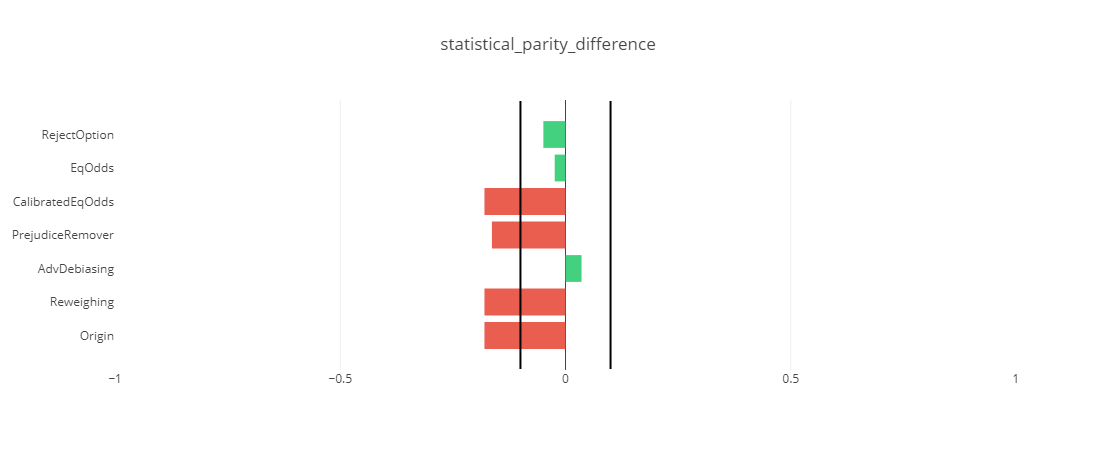

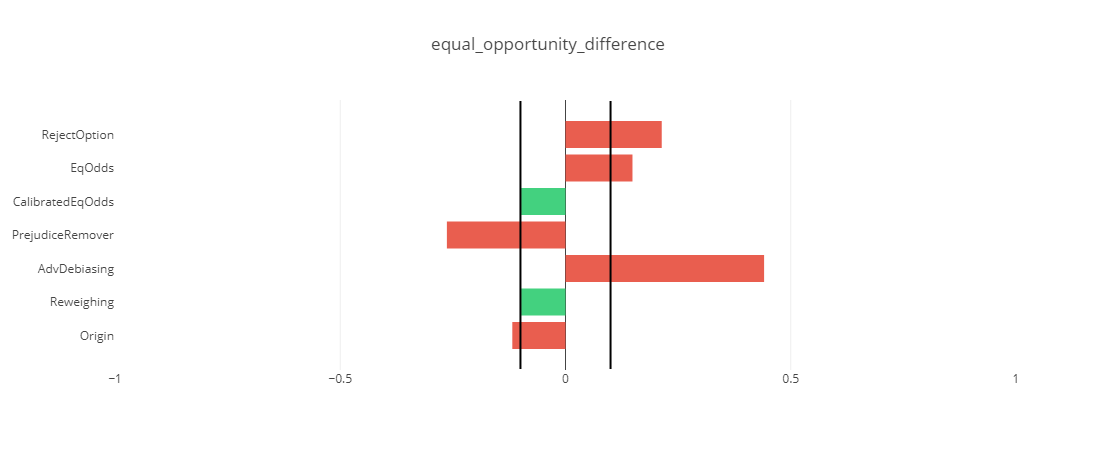

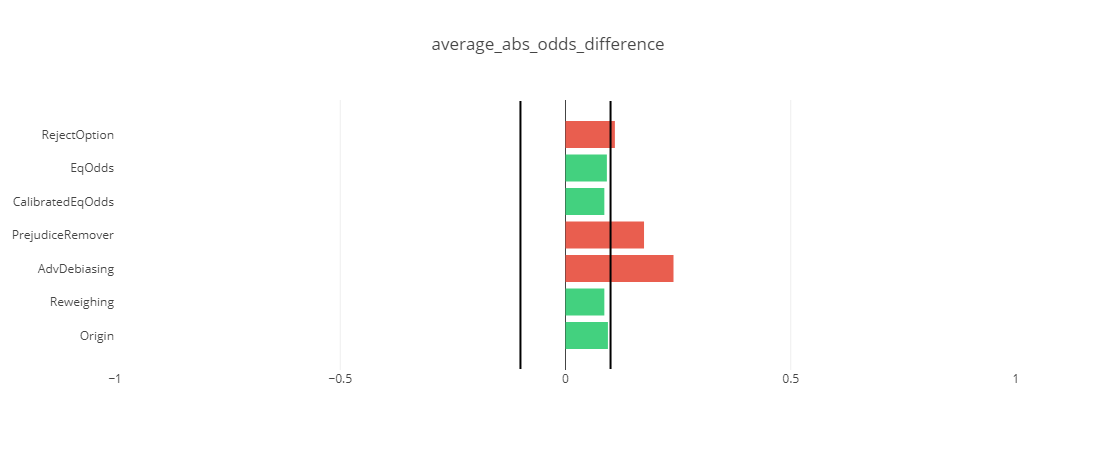

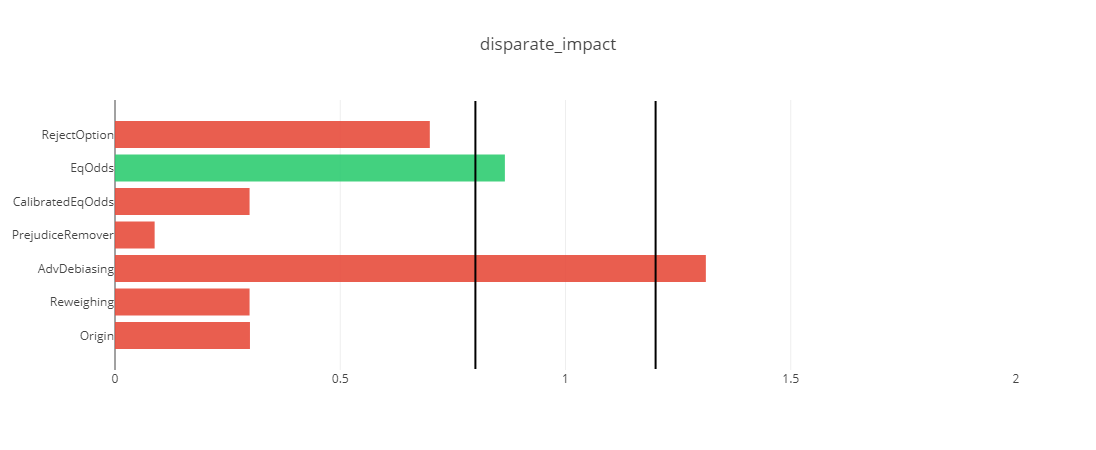

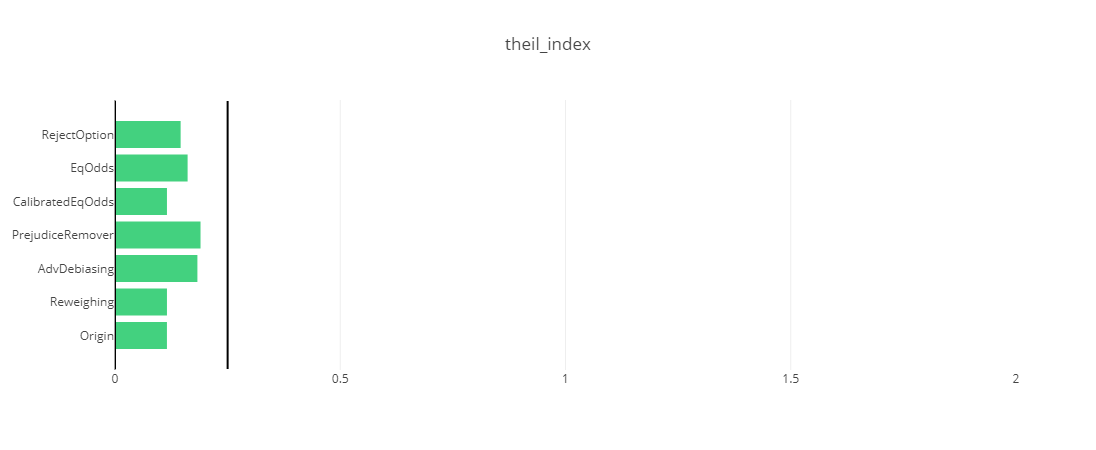

score  nb_valid
EqOdds            0.560177       4.0
Reweighing        1.181331       3.0
CalibratedEqOdds  1.181331       3.0
RejectOption      0.819246       2.0
Origin            1.207843       2.0
AdvDebiasing      1.210593       2.0
PrejudiceRemover  1.702787       1.0

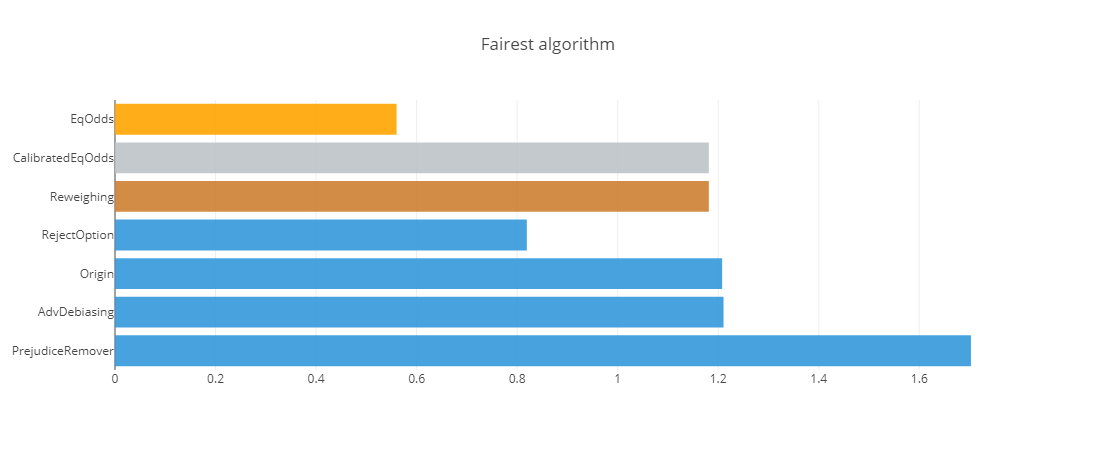

In [58]:
compare_fair_metrics(algo_metrics)

#### Find the fairest algorithm

score  nb_valid
EqOdds            1.875468       5.0
AdvDebiasing      2.441138       5.0
Reweighing        2.847480       4.0
CalibratedEqOdds  2.847480       4.0
RejectOption      2.171642       3.0
PrejudiceRemover  2.865310       3.0
Origin            2.874613       3.0

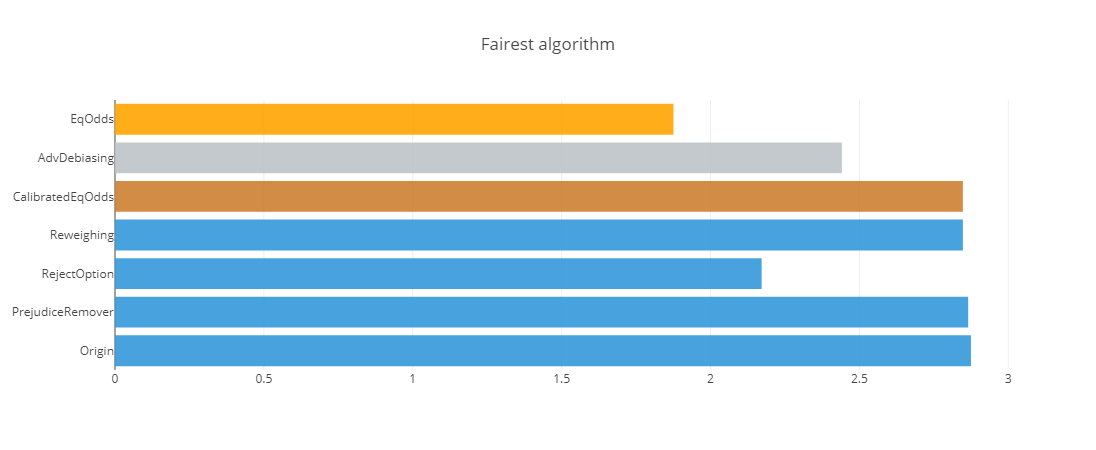

In [59]:
final = score_all_attr(algo_metrics)
plot_score_fair_metrics(final)

## 4. Interpretable model
### 4.1 Feature importance

In [38]:
rf.feature_importances_
feature_imp = pd.Series(rf.feature_importances_, index=data_orig_train.feature_names)
feature_imp.sort_values(ascending=False, inplace=True)

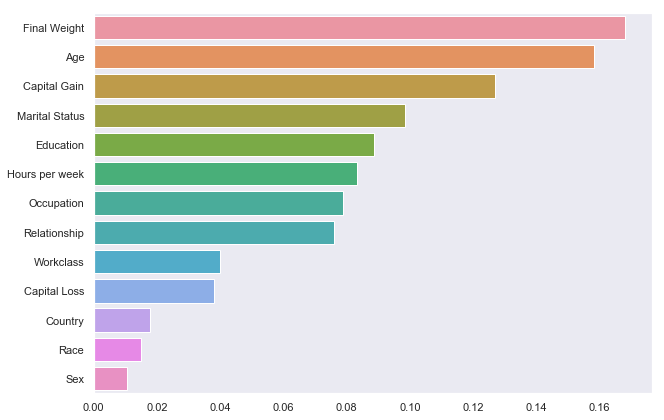

In [39]:
plt.figure(figsize=(10,7))
ax = sns.barplot(y=feature_imp.index.values, x=feature_imp,orient='h')

### 4.2 LIME

In [40]:
test_interp = pd.DataFrame(data=data_orig_test.features,
                            columns=data_orig_test.feature_names)

categorical_features = ["Workclass", "Education", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Country"]
categorical_features_idx = [np.where(test_interp.columns.values == col)[0][0] for col in categorical_features]
categorical_names_LIME = {}

for feature, idx in zip(categorical_features, categorical_features_idx):
    categorical_names_LIME[idx] = categorical_names[feature]

explainer = lime.lime_tabular.LimeTabularExplainer(test_interp.values,
                                                   feature_names=test_interp.columns.values,
                                                   class_names=['Income <= 50K', 'Income > 50K'],
                                                   categorical_features=categorical_features_idx, 
                                                   categorical_names=categorical_names_LIME)

row = pd.DataFrame(data=[test_interp.iloc[2,:]], columns=test_interp.columns.values)
display(row)

exp = explainer.explain_instance(row.values[0], rf.predict_proba, num_features=7)
exp.show_in_notebook(show_table=True, show_all=False)

Age  Hours per week  Relationship  Capital Gain  Workclass  \
2  0.616438         0.44898           5.0           0.0        0.0   

   Capital Loss  Country  Race  Marital Status  Final Weight  Education  Sex  \
2           0.0     39.0   4.0             2.0      0.115729       15.0  0.0   

   Occupation  
2         0.0

### 4.3 SHAP

In [41]:
t0 = time()
print('start : %0.4f'%((time() - t0)))

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)
print('explainer end : %0.4f'%((time() - t0)))

# Calculate Shap values
test = test_interp.iloc[0:10,:]
shap_values = explainer.shap_values(test)
print('shap values end : %0.4f'%((time() - t0)))

start : 0.0000
explainer end : 0.0868
shap values end : 5.6717


In [42]:
def plot_shap_explain(data, idx, model, explainer, shap_values, categorical_features=None, encoders=None):
    row = data.iloc[idx,:] 
    
    proba = model.predict_proba([row])[0]
    display(Markdown("Probability of having an Income <= 50K : **%0.2f**"%proba[0]))
    display(Markdown("Probability of having an Income > 50K : **%0.2f**"%proba[1]))
    
    if categorical_features != None:
        for feature in categorical_features:
            row[feature] = encoders[feature].inverse_transform([int(row[feature])])[0]
    
    display(Markdown("#### Explaination based on the 0 label (Income <= 50K)"))
    display(shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], row))
    display(Markdown("#### Explaination based on the 1 label (Income > 50K)"))
    display(shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], row))

shap.initjs()
# display(shap.summary_plot(shap_values, test))
plot_shap_explain(test_interp, 2, rf, explainer, shap_values, categorical_features, encoders)

Probability of having an Income <= 50K : **0.63**

Probability of having an Income > 50K : **0.37**

#### Explaination based on the 0 label (Income <= 50K)

#### Explaination based on the 1 label (Income > 50K)

## 5. Conclusion